# Brain MRI Images for Tumor Detection

[Data](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

[Pytorch](https://pytorch.org/)

[Torchvision Docs](https://pytorch.org/vision/stable/index.html)

The goal of this notebook is to recognize which brain scan has a tumor and which does not by using a simple CNN. As I have experimented with the dataset I have found that there is little that needs to be done to the data to achieve a realtively accurate model.

The method that I have implemented is a 4 layer CNN with 4 fully connected layers. The data is transformed using the Torchvision package from Pytorch. The images are resized to a 63x63 pixel rgb image and have a random rotation from 0-10 degrees applied during training.

To help with data visualization I am using some of the image displaying utilities from the Udacity intro to Pytorch course. In my initial attempts I used OpenCV to crop the images but found that did not improve my results enough to warrant its impementation.

In [22]:
# Import libraries and tools
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Pytorch assests
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler

# Pytorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [23]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

CUDA is available! Training on GPU...


In [24]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

### Data Pre-processing

The data is actually fairly usable in the original state. I applied some very simple transforms to the data and achieved a model with accuracy of around 85-95 percent.

In [25]:
# Utility to show an image from Udacity intro to pytorch
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.48, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [26]:
# Data directory
present_directory = os.getcwd()
path = f"{present_directory}/brain_tumor_dataset"

In [27]:
# Data transforms to convert data to a tensor and apply a normalization
# augment the training and validation datasets
vis_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(63),
    transforms.ToTensor(),
])

In [28]:
#Create a dataset and a dataloader to visualize the data
vis_dataset = datasets.ImageFolder(path, transform=vis_transform)
vis_dataloader = torch.utils.data.DataLoader(vis_dataset, batch_size=batch_size, shuffle=True)

torch.Size([16, 3, 63, 63])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


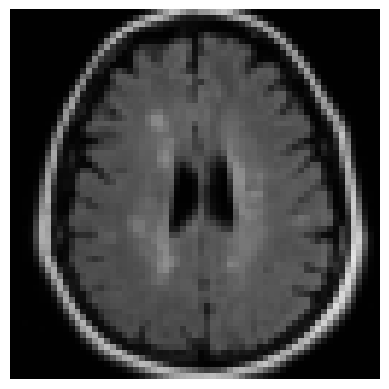

In [29]:
# load and display an image with its label
images, labels = next(iter(vis_dataloader))
imshow(images[0], normalize = False)
print(images.shape)
print(labels)

In [30]:
# Transformations for training and testing data
train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(63),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(63),
    transforms.ToTensor(),
])

In [31]:
#Setup a dataset and apply our transforms to the input data
train_data = datasets.ImageFolder(path, transform=train_transform)
test_data = datasets.ImageFolder(path, transform=test_transform)

In [32]:
# Create indices for our training and validation data
num_train = len(train_data)
# Create a list of indices
indices = list(range(num_train))
# Shuffle those indices
np.random.shuffle(indices)
# Get the 80/20 index
split = int(np.floor(valid_size*num_train))
# Get the indices for the training index and the validation index 
train_idx, valid_idx = indices[split:], indices[:split]

In [33]:
# Define a sampler for the data
# SubsetRandomSampler samples elements randomly from a list of indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [34]:
# Prepare data loaders
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    drop_last=True
)

valid_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True
)

In [35]:
# Show the size of the different loaders
print("number of training samples: " + str(len(train_sampler)))
print("number of validation samples: " + str(len(valid_sampler)))
print("number of test samples: " + str(len(test_data)))

number of training samples: 203
number of validation samples: 50
number of test samples: 253


In [36]:
# We have two classes, either there is a tumor or there is not
classes = ["no", "yes"]
classes

['no', 'yes']

0
torch.Size([16, 3, 63, 63])
0
torch.Size([16, 3, 63, 63])
1
torch.Size([16, 3, 63, 63])
1
torch.Size([16, 3, 63, 63])


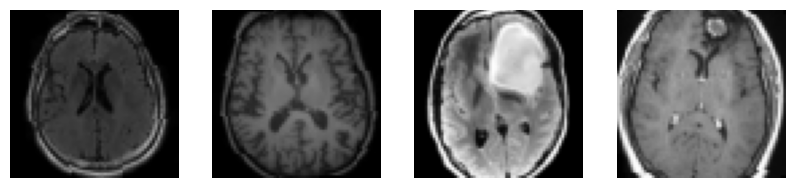

In [37]:
# Visualize training data
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii],ax=ax,normalize=False)
    print(labels[ii].numpy())
    print(images.shape)

images = images.numpy()

In [38]:
# Define a CNN to train for the data
class Tumor(nn.Module):
    def __init__(self):
        super(Tumor, self).__init__()
        #define two convolutional layers with a stride of 1 and a kernel/filter size of 3
        # layer 1 with 63x63x3 tensor
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        # layer 2 with 63x63x16 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        # layer 3 with 31x31x32 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        # layer 4 with 31x31x64 tensor
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)

        #the output of the convolutional layer will be a 31x31 image with 128 output channels
        self.fc1 = nn.Linear(128*15*15, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 2)

        # this will halve the x and y dimensions after each convolution
        self.pool = nn.MaxPool2d(2,2)

        # dropout percentage for the linear layers
        self.dropout = nn.Dropout(p=0.35)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.shape[0], -1)


        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x=F.log_softmax(x, dim=1)

        return x

In [39]:
#Define a model
model = Tumor()
if train_on_gpu:
    model.cuda()
model

Tumor(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=28800, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [40]:
#Loss function: Negative Log Likelyhood Loss function
criterion = nn.NLLLoss()
#Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### Training loop

In [41]:
# number of training epochs
n_epochs = 50
# variable to track validation loss
valid_loss_min = np.Inf

for epoch in range(1,n_epochs+1):
    #training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        # move tensors to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # perform a forward pass on the data
        output = model.forward(data)
        # calculate the loss using Cross Entropy Loss
        loss = criterion(output,target)
        # zero the gradient
        optimizer.zero_grad()
        # update training loss
        train_loss+=loss.item()
        # backpropogate the model to calculate the gradient
        loss.backward()
        # step the optimizer to update the weights
        optimizer.step()
        
    
    # Validate the model
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model.forward(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'tumor_detector.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.672419 	Validation Loss: 0.707349
Validation loss decreased (inf --> 0.707349).  Saving model ...
Epoch: 2 	Training Loss: 0.636118 	Validation Loss: 0.729286
Epoch: 3 	Training Loss: 0.616685 	Validation Loss: 0.704163
Validation loss decreased (0.707349 --> 0.704163).  Saving model ...
Epoch: 4 	Training Loss: 0.593266 	Validation Loss: 0.725801
Epoch: 5 	Training Loss: 0.553552 	Validation Loss: 0.745029
Epoch: 6 	Training Loss: 0.547851 	Validation Loss: 0.671979
Validation loss decreased (0.704163 --> 0.671979).  Saving model ...
Epoch: 7 	Training Loss: 0.545931 	Validation Loss: 0.831808
Epoch: 8 	Training Loss: 0.543589 	Validation Loss: 0.674142
Epoch: 9 	Training Loss: 0.529274 	Validation Loss: 0.865890
Epoch: 10 	Training Loss: 0.558751 	Validation Loss: 0.684122
Epoch: 11 	Training Loss: 0.545739 	Validation Loss: 0.764072
Epoch: 12 	Training Loss: 0.528752 	Validation Loss: 0.695867
Epoch: 13 	Training Loss: 0.504354 	Validation Loss: 0.799158
E

In [42]:
#reload the model
model.load_state_dict(torch.load('tumor_detector.pt'))

<All keys matched successfully>

In [43]:
# initialize test loss
test_loss = 0.0
# create a list to track the classifications of the model (tumor or no tumor)
class_correct = [0.0, 0.0]
# create a list to track the total number in each class
class_total = [0.0, 0.0]

model.eval()
for data, target in test_loader:
    with torch.no_grad():
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
    
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        
        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss/len(test_loader)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.290621

Test Accuracy of    no: 90% (84/93)
Test Accuracy of   yes: 87% (129/147)

Test Accuracy (Overall): 88% (213/240)


In [44]:
# helper function to un-normalize and display an image
def plot_imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

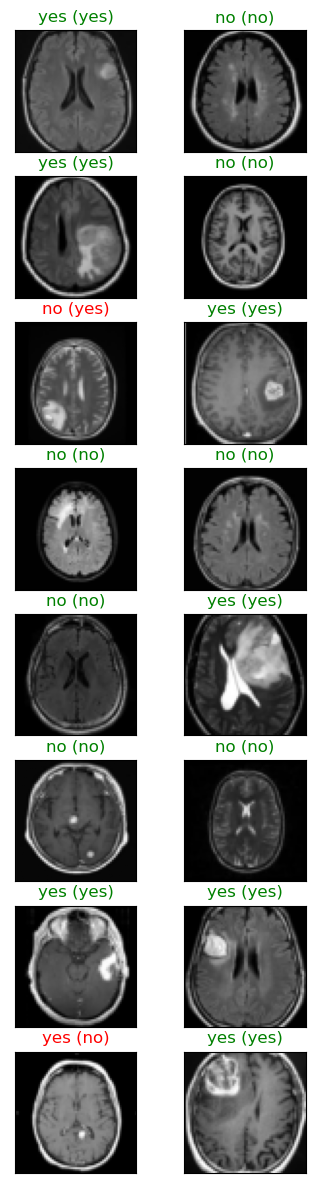

In [45]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(4, 30))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(batch_size, 2, idx+1, xticks=[], yticks=[])
    plot_imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))